# Experiment 1

In this experiment, we try to optimize the parameter of a simple exponential smoothing system with pytorch.

## Setup 

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 5)
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

from utils import *

from trading_strategies import *
test_RS_Trading_Strategy()

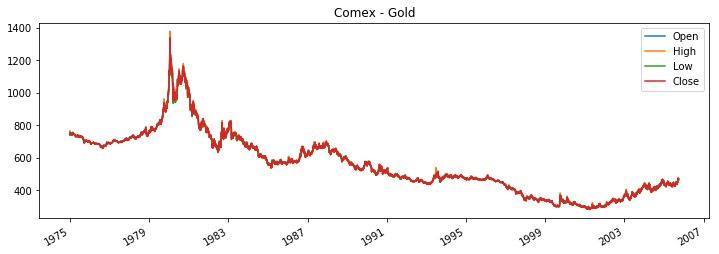

In [3]:
price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
           names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
           index_col=0)

price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Comex - Gold')
plt.show()

In [4]:
a =  2 / 501
gold_es0 = ES1_Trading_Strategy(price, a=a, name='Comex - Gold')
gold_es0.excecute()

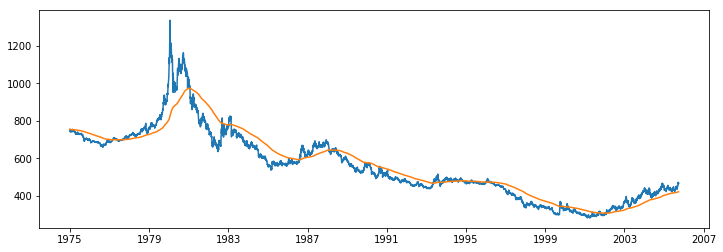

In [5]:
plt.plot(price.Close, label='Close')
plt.plot(Series(data=gold_es0.state['esa'], index=price.index), label='Exp. smoothing')
plt.show()

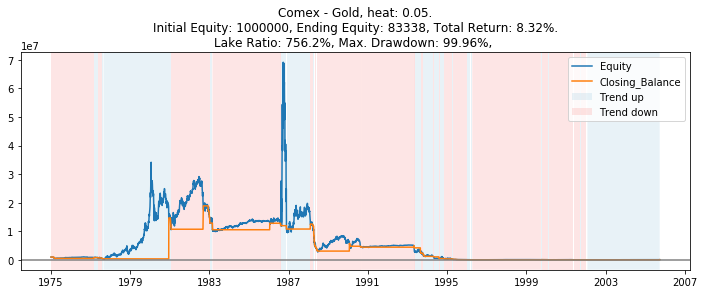

In [6]:
gold_es0.plot_equity()

In [7]:
gold_es0.get_orders()[23:].head(5)

,buy_stop,sell_stop,protective_buy,protective_sell,risk_per_lot,amount
1975-02-03,NaN,NaN,NaN,NaN,NaN,NaN
1975-02-04,NaN,NaN,NaN,NaN,NaN,NaN
1975-02-05,NaN,742.5,753.792777,NaN,11.292777,-4400.0
1975-02-06,NaN,743.4,753.752088,NaN,10.352088,-4800.0
1975-02-07,NaN,NaN,753.709963,NaN,NaN,NaN


In [8]:
gold_es0.get_prices()[23:].head(5)

,Open,High,Low,Close,Volume,Open_Interest
1975-02-03,746.0,746.6,745.0,745.2,800,3653
1975-02-04,743.4,744.4,742.5,744.2,1026,3687
1975-02-05,744.1,744.6,743.4,743.6,716,3627
1975-02-06,741.8,743.6,741.0,743.2,1007,3482
1975-02-07,744.1,744.3,743.3,744.2,702,3528


In [9]:
gold_es0.get_trades().head(5)

,Price,Amount
Date,,
1975-02-06,741.400000,-4800.0
1975-02-13,753.593885,4800.0
1975-02-18,748.750000,-11300.0
1975-02-19,754.236003,11300.0
1975-02-20,752.350000,-37700.0


In [10]:
gold_es0.get_equity()[23:].head(5)

,Available_Balance,Closing_Balance,Position,Open_Profit,Position_Value,Equity
1975-02-03,1000000.0,1000000.0,0.0,0.0,0.0,1000000.0
1975-02-04,1000000.0,1000000.0,0.0,0.0,0.0,1000000.0
1975-02-05,1000000.0,1000000.0,0.0,0.0,0.0,1000000.0
1975-02-06,4558720.0,1000000.0,-4800.0,-8640.0,-3567360.0,991360.0
1975-02-07,4558720.0,1000000.0,-4800.0,-13440.0,-3572160.0,986560.0


In [11]:
gold_es0.position_step

100

## Pytorch

In [12]:
import torch

In [13]:
class Trading_Strategy_Torch:
    """
    Class that performs a trading strategy on a single asset.
    """
    
    def __init__(self, prices, equity=1e6, heat=0.05, position_step=100, name='', **kwargs):
        """
        Defines the initial state and hyper parameters of the trading strategy.
        
        Parameters
        ----------
        prices: DataFrame with columns Date, Open, High, Low, Close
        equity: Initial equity to invest in the asset.
        heat: Proportion of the equity that one is willing to risk.
        position_step: Minimum steps in position' sizes
        name: Name of the asset for plotting purposes.
        """
        self.dates = prices.index
        self.first_trading_day = None
        self.last_trading_day = None
        self.prices_df = prices
        self.prices = {s: prices[s].values for s in list(prices.keys())}
        self.heat = heat
        self.position_step = position_step
        self.name = name
        self.today_prices = None
        
        self.equity = {'Available_Balance': numpy.ones(len(self.dates)) * equity,
                       'Closing_Balance': numpy.ones(len(self.dates)) * equity,
                       'Position': numpy.zeros(len(self.dates)),
                       'Open_Profit': numpy.zeros(len(self.dates)),
                       'Position_Value': numpy.zeros(len(self.dates)),
                       'Equity': numpy.ones(len(self.dates)) * equity}
        
        self.orders = {'buy_stop': numpy.zeros(len(self.dates)) * numpy.nan,
                       'sell_stop': numpy.zeros(len(self.dates)) * numpy.nan,
                       'protective_buy': numpy.zeros(len(self.dates)) * numpy.nan,
                       'protective_sell': numpy.zeros(len(self.dates)) * numpy.nan,
                       'risk_per_lot': numpy.zeros(len(self.dates)) * numpy.nan,
                       'amount': numpy.zeros(len(self.dates)) * numpy.nan}
        
        self.trades = []
        self.max_drawdown = 0
        self.performance = {}
        
        self.init_torch(prices, equity)
        
        self.init_state(**kwargs)
        
    
    
    def init_torch(self, prices, equity):
        self.prices_t = {s: torch.tensor(prices[s].values, dtype=torch.float64) for s in list(prices.keys())}
        
        self.available_balance_t = torch.tensor(equity, dtype=torch.float64, requires_grad=True)
        self.closing_balance_t = torch.tensor(equity, dtype=torch.float64, requires_grad=True)
        self.position_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
        self.position_value_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
        self.equity_t = torch.tensor(equity, dtype=torch.float64, requires_grad=True)
        
        self.buy_stop_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
        self.sell_stop_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
        self.protective_buy_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
        self.protective_sell_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
        self.risk_per_lot_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
        self.amount_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
        
        self.max_drawdown_t = torch.zeros(1, dtype=torch.float64, requires_grad=True)
    
    
    def init_state(self, **kwargs):
        pass
    
    
    def update_state(self, today_i):
        """
        Updates the state as of market close from today_i - 1, for determining orders before market openas today_i.
        """
        pass
    
    
    def orders_before_trading_starts(self, today_i):
        """
        Computes the orders for the day (today).
        
        Parameters
        ----------
        prices : a prices data frame with a Date index and columns: Open, High, Low, Close, Volume.
            Prices until today only for accessing current date.
        prev_day_position : position in the asset at the end of yesterday.
        """
        self.entry_order_prices(today_i)
        self.protective_order_prices(today_i)
        self.order_amounts(today_i)
    
    
    def entry_order_prices(self, today_i):
        """
        Computes the entry orders for the day (today) according to a Support and Resistance system.
        """
        pass
    
    
    def protective_order_prices(self, today_i):
        """
        Computes the protective orders for the day (today) according to a Support and Resistance system.
        """
        pass
    
    
    def order_amounts(self, today_i):
        """
        Sets the order amounts for the day
        """
        equity_to_risk = self.available_balance_t * self.heat  #self.equity['Available_Balance'][today_i - 1] * self.heat

        
        if today_i == 38: # gold_es1.dates[38]
            print('today:', self.dates[today_i])
            print('buy_stop:', self.orders['buy_stop'][today_i])
            print('protective_sell:', self.orders['protective_sell'][today_i])
            
        if self.orders['buy_stop'][today_i] > 0 and self.orders['protective_sell'][today_i] > 0:
            self.risk_per_lot_t = self.buy_stop_t - self.protective_sell_t + 1e-12
            self.amount_t = self.position_step * \
                    torch.round((1e-8 + equity_to_risk / self.risk_per_lot_t) / self.position_step)
        
        elif self.orders['sell_stop'][today_i] > 0 and self.orders['protective_buy'][today_i] > 0:
            self.risk_per_lot_t = self.protective_buy_t - self.sell_stop_t + 1e-12
            self.amount_t = - self.position_step * \
                torch.round((1e-8 + equity_to_risk / self.risk_per_lot_t) / self.position_step)
        else:
            pass
        
        self.orders['risk_per_lot'][today_i] = self.risk_per_lot_t.detach().numpy()
        self.orders['amount'][today_i] = self.amount_t.detach().numpy()
    
    
    def excecute_orders(self, today_i, skid=0.5):
        """
        Excecutes orders during the day.
        """
        
#         position = self.equity['Position'][today_i - 1]  # previous day's position
        balance = self.available_balance_t  #self.equity['Available_Balance'][today_i - 1]  # previous day's balance
        o = {k: self.orders[k][today_i] for k in self.orders.keys()}  # orders for the day
        tp = self.today_prices

        if self.position_t == 0:  # Enter the market.

            if not numpy.isnan(o['buy_stop']) and not numpy.isnan(o['protective_sell']) and \
                o['buy_stop'] > o['protective_sell'] and tp['High'] > o['buy_stop']:
                
                buy_price = tp['High'] - skid * (tp['High'] - max(tp['Open'], tp['Low'], self.buy_stop_t))
                trade = {'Date': self.dates[today_i],
                         'Price': float(buy_price.detach().numpy()),
                         'Amount': min(o['amount'], float(balance.detach().numpy()))}
                self.position_t = self.position_t + o['amount']
                balance = balance - o['amount'] * buy_price
                self.trades.append(trade)


            elif not numpy.isnan(o['sell_stop']) and not numpy.isnan(o['protective_buy']) and \
                o['sell_stop'] < o['protective_buy'] and tp['Low'] < o['sell_stop']:
                
                sell_price = tp['Low'] + skid * (min(tp['Open'], tp['High'], self.sell_stop_t) - tp['Low'])
                trade = {'Date': self.dates[today_i],
                         'Price': float(sell_price.detach().numpy()),
                         'Amount': max(o['amount'], float(-balance.detach().numpy()))}  # o['amount'] < 0
                self.position_t = self.position_t + o['amount']
                balance = balance - o['amount'] * sell_price
                self.trades.append(trade)

        if self.position_t != 0:  # Close positions.

            if not numpy.isnan(o['protective_buy']) and tp['High'] > o['protective_buy']:
                
                buy_price = tp['High'] - skid * (tp['High'] - max(tp['Open'], tp['Low'], self.protective_buy_t))
                self.amount_t = max(-self.position_t, torch.zeros(1, dtype=torch.float64))
                trade = {'Date': self.dates[today_i],
                         'Price': float(buy_price.detach().numpy()),
                         'Amount': float(self.amount_t.detach().numpy())}
                self.position_t = self.position_t + self.amount_t
                balance = balance - self.amount_t * buy_price
                self.trades.append(trade)

            if not numpy.isnan(o['protective_sell']) and tp['Low'] < o['protective_sell']:
                
                sell_price = tp['Low'] + skid * (min(tp['Open'], tp['High'], self.protective_sell_t) - tp['Low'])
                self.amount_t = min(-self.position_t, torch.zeros(1, dtype=torch.float64))
                trade = {'Date': self.dates[today_i],
                         'Price': float(sell_price.detach().numpy()),
                         'Amount': float(self.amount_t.detach().numpy())}
                self.position_t = self.position_t + self.amount_t
                balance = balance - self.amount_t * sell_price
                self.trades.append(trade)

        if self.dates[today_i] == self.dates[-1] and self.position_t != 0:  # Last day
            
            if self.position_t > 0:
                
                sell_price = tp['Low'] + skid * (min(tp['Open'], tp['Close'], tp['High']) - tp['Low'])
                self.amount_t = min(-self.position_t, torch.zeros(1, dtype=torch.float64))
                trade = {'Date': self.dates[today_i],
                         'Price': float(sell_price.detach().numpy()),
                         'Amount': float(self.amount_t.detach().numpy())}
                self.position_t = self.position_t + self.amount_t
                balance = balance - self.amount_t * sell_price
                self.trades.append(trade)
                
            else:  # position < 0
                
                buy_price = tp['High'] - skid * (tp['High'] - max(tp['Open'], tp['Close'], tp['Low']))
                self.amount_t = max(-position, torch.zeros(1, dtype=torch.float64))
                trade = {'Date': self.dates[today_i],
                         'Price': float(buy_price.detach().numpy()),
                         'Amount': float(self.amount_t.detach().numpy())}
                self.position_t = self.position_t + self.amount_t
                balance = balance - self.amount_t * buy_price
                self.trades.append(trade)

        if self.position_t != 0:
            self.open_profit_t = self.position_t * (tp['Close'] - torch.tensor(self.trades[-1]['Price'], dtype=torch.float64))
        else:
            self.open_profit_t = torch.zeros(1)

        if self.equity['Position'][today_i - 1] != 0 and self.position_t == 0:
            self.closing_balance_t = balance

        self.available_balance_t = balance
        self.position_value_t = self.position_t * tp['Close']
        self.equity_t = balance + self.position_t * tp['Close']
        
        self.equity['Available_Balance'][today_i] = balance.detach().numpy()
        self.equity['Closing_Balance'][today_i] = self.closing_balance_t.detach().numpy()
        self.equity['Position'][today_i] = self.position_t.detach().numpy()
        self.equity['Open_Profit'][today_i] = self.open_profit_t.detach().numpy()
        self.equity['Position_Value'][today_i] = self.position_t.detach().numpy() * tp['Close']
        self.equity['Equity'][today_i] = balance.detach().numpy() + self.position_t.detach().numpy() * tp['Close']
    
    
    
    
    def excecute(self, warmup=25, end=None, skid=0.5):
        """
        Excecutes the trading strategy and computes its performance measures.
        
        Parameters
        ----------
        warmup: warmup period in days or a proportion from 0 to 1.
        end: either a datetime or a proportion from 0 to 1 (all sample).
        """
        peak = self.equity['Equity'][0]
        low = peak
        drawdown = 0
        max_drawdown = 0
        
        if end is None:
            end = self.dates[-1]
        elif type(end) == float:
            end = self.dates[int(len(self.dates) * end)]
        
        
        if warmup < 1:
            warmup = int(len(self.dates) * warmup)
            
        self.first_trading_day = self.dates[warmup]
        self.last_trading_day = end
        
        for i in range(1, len(self.dates)):
            self.today_prices = {k: self.prices_t[k][i] for k in self.prices_t.keys()}
            self.update_state(i)
            if i >= warmup:
                self.orders_before_trading_starts(i)
                self.excecute_orders(i, skid)
                
                # Max drawdown
                if self.equity['Equity'][i] > peak:
                    peak = self.equity['Equity'][i]
                    low = peak
                if self.equity['Equity'][i] < low:
                    low = self.equity['Equity'][i]
                    drawdown = low / peak - 1
                max_drawdown = min(drawdown, max_drawdown)
                
            if self.dates[i] > end:
                self.equity['Available_Balance'][i] = self.equity['Available_Balance'][i - 1]
                self.equity['Closing_Balance'][i] = self.equity['Closing_Balance'][i - 1]
                self.equity['Position'][i] = self.equity['Position'][i - 1]
                self.equity['Open_Profit'][i] =  self.equity['Position'][i] * \
                    (self.prices['Close'][i] - self.trades[-1]['Price'])
                self.equity['Position_Value'][i] = self.equity['Position'][i] * self.prices['Close'][i]
                self.equity['Equity'][i] = self.equity['Equity'][i - 1]
        
        self.max_drawdown = max_drawdown
        self.compute_performance()
    
    
    def compute_performance(self):
        """
        Computes performance indicators for the trading strategy.
        """
        
        self.performance['Years'] = (self.last_trading_day - self.first_trading_day).days / 364.25
        self.performance['Ratio'] = self.equity['Equity'][-1] / self.equity['Equity'][0]
        # Instantaneously Compounding Annual Gain
        self.performance['ICAGR'] = numpy.log(self.performance['Ratio']) / self.performance['Years']
        self.performance['Max_Drawdown'] = -self.max_drawdown
        # How Often the System Earns Back its Biggest Drawdown
        self.performance['Bliss'] = self.performance['ICAGR'] / self.performance['Max_Drawdown']
        
        eqty = self.equity['Equity'][self.dates > self.first_trading_day]
        self.performance['Volatility'] = numpy.std(numpy.log(eqty[1:] / eqty[:-1])) * numpy.sqrt(364.25)
        
        # Lake Ratio (see http://www.seykota.com/tribe/risk/index.htm)
        lake_bottom = Series(eqty) / self.equity['Equity'][1]
        lake_surface = lake_bottom.cummax()

        earth = numpy.trapz(lake_bottom.values)
        water = numpy.trapz(lake_surface - lake_bottom)
        self.performance['Lake_Ratio'] = water / earth
        
        earth0 = numpy.trapz(lake_bottom.values - 1)
        self.performance['Sea_Ratio'] = water / earth0
    
    
    
    def get_prices(self):
        return self.prices_df
    
    
    def get_state(self):
        if not any([i == 'state_df' for i in dir(self)]):
            self.state_df = DataFrame(self.state, index=self.dates).iloc[:-1]
        return self.state_df
    
    
    def get_orders(self):
        if not any([i == 'orders_df' for i in dir(self)]):
            self.orders_df = DataFrame(self.orders, index=self.dates)
        return self.orders_df
    
    
    def get_trades(self):
        if not any([i == 'trades_df' for i in dir(self)]):
            self.trades_df = dict_list_to_DataFrame(self.trades).set_index('Date')
        return self.trades_df
    
    
    def get_equity(self):
        if not any([i == 'equity_df' for i in dir(self)]):
            self.equity_df =DataFrame(self.equity, index=self.dates)
        return self.equity_df
    
    
    
    def plot_prices(self):
        fig, ax = pyplot.subplots()
        ax.plot(self.prices_df.Open)
        ax.plot(self.prices_df.High)
        ax.plot(self.prices_df.Low)
        ax.plot(self.prices_df.Close)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.set_title(self.name)
        ax.legend()
    
    
    def plot_state(self):
        x = pandas.merge(self.prices_df[['Open', 'High', 'Low', 'Close']],
                         self.get_state(), left_index=True, right_index=True, how='outer')
        x.plot()
    
    
    def plot_equity(self):
        x = pandas.merge(self.get_equity(), self.get_state(), left_index=True, right_index=True, how = 'outer')
        tit = self.name + ', '
        tit += 'heat: ' + str(self.heat) + '.\n'
        tit += 'Initial Equity: ' + str(int(self.equity['Equity'][0]))
        tit += ', Ending Equity: ' + str(int(self.equity['Equity'][-1])) + ', '
        tit += 'Total Return: ' + str(int(10000 * self.equity['Equity'][-1] / self.equity['Equity'][1] - 1) / 100) + '%.\n'
#         tit += 'ICAGR: ' + str(int(10000 * self.performance['ICAGR']) / 100) + '%.\n'
#         tit += 'Volatility: ' + str(int(10000 * self.performance['Volatility']) / 100) + '%, '
        tit += 'Lake Ratio: ' + str(int(10000 * self.performance['Lake_Ratio']) / 100) + '%, '
        tit += 'Max. Drawdown: ' + str(int(10000* self.performance['Max_Drawdown']) / 100) + '%, '
#         tit += 'Bliss: ' + str(numpy.round(364.25 * self.performance['Bliss'], 1)) + ' days.'
        pal = pyplot.get_cmap('Paired').colors
        fig, ax = pyplot.subplots()
        trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(x.index, 0, x.Equity.max(), where= x.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
        ax.fill_between(x.index, 0, x.Equity.max(), where= x.Trend < 0, facecolor=pal[4],
                        alpha=0.25, transform=trans, label='Trend down')
        ax.plot(x.index, x.Equity)
        ax.plot(x.index, x.Closing_Balance)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.set_title(tit)
        ax.legend()
    
    
    def plot_lake_ratio(self):
        """
        Illustrates the computation of the lake ratio.
        See http://www.seykota.com/tribe/risk/index.htm
        """
        eqty = self.equity['Equity'][self.dates > self.first_trading_day]
        lake_bottom = Series(eqty) / self.equity['Equity'][1]
        lake_surface = lake_bottom.cummax()
        fig, ax = pyplot.subplots()
        ax.fill_between(lake_bottom.index, y1 = lake_bottom, y2 = lake_surface, alpha=0.5)
        ax.fill_between(lake_bottom.index, y1 = 0, y2 = lake_bottom, alpha=0.5)
        ax.axhline(1, color='grey', lw=2, alpha=0.75)
        ax.axhline(0, color='grey', lw=2, alpha=0.75)
        ax.plot(lake_bottom)
        tit = 'Lake Ratio: ' + str(int(10000 * self.performance['Lake_Ratio']) / 100) + '%'
        tit += ', Sea Ratio (areas over 1): ' + str(int(10000 * self.performance['Sea_Ratio']) / 100) + '%.'
        ax.set_title(tit)



In [14]:
class ES1_Trading_Strategy_Torch(Trading_Strategy_Torch):
    """
    Implements a simple exponential smoothing trading system.
    """
    
    def init_state(self, a=0.1):
        """
        Parameters
        ----------
        a: exponential smoothing constant between 0 and 1. S_t = a * P_t + (1 - a) * S_t-1
        """

        self.state = {'esa': numpy.zeros(len(self.dates)) * numpy.nan,
                      'Trend': numpy.zeros(len(self.dates)) * numpy.nan}
        
        self.trend_t = torch.zeros(1, requires_grad=True, dtype=torch.float64)
        self.esa_t = torch.zeros(1, requires_grad=True, dtype=torch.float64)
        self.a_t = torch.tensor(min(max(a, 0), 1), requires_grad=True, dtype=torch.float64)        
    
    
    def update_state(self, today_i):
        """
        Updates the Resistance, Support, and Trend variables.
        """
        if today_i == 1:
            self.esa_t = self.prices_t['Close'][0]
            
        else:
            self.esa_t = self.a_t * self.prices['Close'][today_i - 1] + \
                (1 - self.a_t) * self.esa_t
            self.trend_t = torch.sign(self.prices_t['Close'][today_i - 1] - self.esa_t)
            
        self.state['esa'][today_i - 1] = self.esa_t.detach().numpy()
        self.state['Trend'][today_i - 1] = self.trend_t.detach().numpy()
    
    
    def entry_order_prices(self, today_i):
        """
        Computes the entry orders for the day (today).
        """
        
        if self.position_t == 0:
            if self.trend_t == 1:
                self.buy_stop_t = self.prices_t['High'][today_i - 1]
                self.orders['buy_stop'][today_i] = self.buy_stop_t.detach().numpy()
            elif self.trend_t == -1:
                self.sell_stop_t = self.prices_t['Low'][today_i - 1]
                self.orders['sell_stop'][today_i] = self.sell_stop_t.detach().numpy()
            else:
                pass
        else:
            pass
    
    
    
    def protective_order_prices(self, today_i):
        """
        Computes the protective orders for the day (today) according to a Support and Resistance system.
        """
        state = {k: self.state[k][today_i - 1] for k in self.state.keys()}
        prev_day_position = self.equity['Position'][today_i - 1]
        
        if self.orders['buy_stop'][today_i] > 0 or prev_day_position > 0:
            self.protective_sell_t = self.esa_t
            self.orders['protective_sell'][today_i] = self.protective_sell_t.detach().numpy()
            
        elif self.orders['sell_stop'][today_i] > 0 or prev_day_position < 0:
            self.protective_buy_t = self.esa_t
            self.orders['protective_buy'][today_i] = self.protective_buy_t.detach().numpy()
            
        else:
            pass
    


In [15]:
gold_es1 = ES1_Trading_Strategy_Torch(price, a=a, name = 'Comex - Gold (Torch)')

In [16]:
gold_es1.excecute()

# for i in range(1, len(gold_es1.dates)):
#             gold_es1.today_prices = {k: gold_es1.prices[k][i] for k in gold_es1.prices.keys()}
#             gold_es1.update_state(i)
#             gold_es1.orders_before_trading_starts(i)

today: 1975-02-26 00:00:00
buy_stop: nan
protective_sell: nan


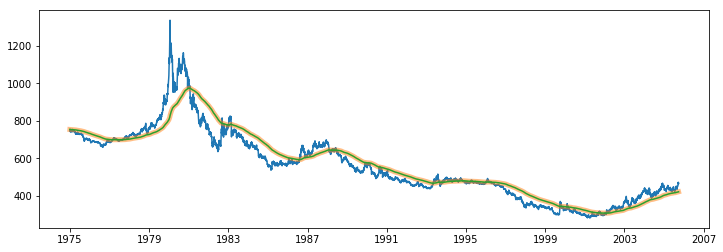

In [17]:
plt.plot(price.Close, label='Close')
plt.plot(Series(data=gold_es0.state['esa'], index=price.index), label='Exp. smoothing', lw=5, alpha=0.5)
plt.plot(Series(data=gold_es1.state['esa'], index=price.index), label='Exp. smoothing (Torch)')
plt.show()

assert np.all(gold_es0.state['esa'][:-1] == gold_es1.state['esa'][:-1])

In [18]:
gold_es1.equity_t

tensor([ 83338.8638], dtype=torch.float64)

In [19]:
# gold_es1.trend_t.backward()
# gold_es1.esa_t.backward()
# gold_es1.equity_t.backward()
Ratio = gold_es1.equity_t / gold_es1.equity['Equity'][0]
Ratio

tensor(1.00000e-02 *
       [ 8.3339], dtype=torch.float64)

In [20]:
Ratio.backward()

In [21]:
gold_es1.a_t.grad

tensor(2642.1848, dtype=torch.float64)

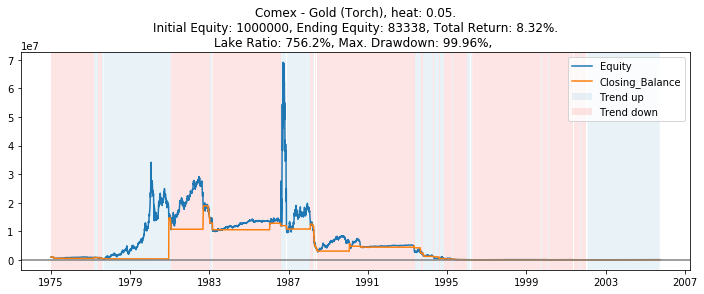

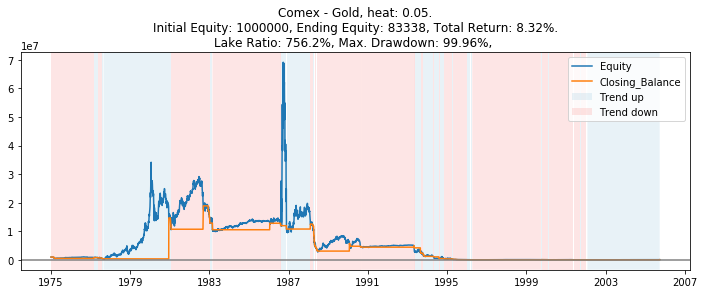

In [22]:
gold_es1.plot_equity()
gold_es0.plot_equity()

In [23]:
r = 20
pd.set_option('display.max_rows', r)
i = 24
gold_es0.get_orders()[i:].head(r)

,buy_stop,sell_stop,protective_buy,protective_sell,risk_per_lot,amount
1975-02-04,NaN,NaN,NaN,NaN,NaN,NaN
1975-02-05,NaN,742.5,753.792777,NaN,11.292777,-4400.0
1975-02-06,NaN,743.4,753.752088,NaN,10.352088,-4800.0
1975-02-07,NaN,NaN,753.709963,NaN,NaN,NaN
1975-02-10,NaN,NaN,753.671999,NaN,NaN,NaN
1975-02-11,NaN,NaN,753.627401,NaN,NaN,NaN
1975-02-13,NaN,NaN,753.587770,NaN,NaN,NaN
1975-02-14,NaN,747.1,753.584226,NaN,6.484226,-7300.0
1975-02-18,NaN,749.4,753.577104,NaN,4.177104,-11300.0
1975-02-19,NaN,NaN,753.572005,NaN,NaN,NaN


In [24]:
gold_es1.get_orders()[i:].head(r)

,buy_stop,sell_stop,protective_buy,protective_sell,risk_per_lot,amount
1975-02-04,NaN,NaN,NaN,NaN,NaN,NaN
1975-02-05,NaN,742.5,753.792777,NaN,11.292777,-4400.0
1975-02-06,NaN,743.4,753.752088,NaN,10.352088,-4800.0
1975-02-07,NaN,NaN,753.709963,NaN,10.352088,-4800.0
1975-02-10,NaN,NaN,753.671999,NaN,10.352088,-4800.0
1975-02-11,NaN,NaN,753.627401,NaN,10.352088,-4800.0
1975-02-13,NaN,NaN,753.587770,NaN,10.352088,-4800.0
1975-02-14,NaN,747.1,753.584226,NaN,6.484226,-7300.0
1975-02-18,NaN,749.4,753.577104,NaN,4.177104,-11300.0
1975-02-19,NaN,NaN,753.572005,NaN,4.177104,-11300.0


In [ ]:
assert (gold_es1.get_orders().sell_stop - gold_es0.get_orders().sell_stop).abs().max() == 0
assert (gold_es1.get_orders().buy_stop - gold_es0.get_orders().buy_stop).abs().max() == 0
assert (gold_es1.get_orders().protective_buy - gold_es0.get_orders().protective_buy).abs().max() == 0
assert (gold_es1.get_orders().protective_sell - gold_es0.get_orders().protective_sell).abs().max() == 0

In [ ]:
gold_es0.get_equity()[i:].head(r)

In [ ]:
gold_es1.get_equity()[i:].head(r)

In [ ]:
gold_es0.get_trades()[5:].head(10)

In [ ]:
gold_es1.get_trades()[5:].head(10)

In [ ]:
max(gold_es1.equity_t.detach().numpy(), 0)